In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from model_very_simple_conv_32 import ConvNet


DIR_PATH = os.getcwd() + '/../'

/vol/bitbucket/hzd21/msc_project/env_pyrep/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Check data

colors = (
    'FF0000',
    '00FF00',
    '0000FF',
    )


for col in colors:
    demo_data = np.load(f'{DIR_PATH}data/demo_reach_cuboid_{col}_camera32.npz')
    for k in demo_data.keys():
        print(col, k, demo_data[k].shape, demo_data[k].dtype)

FF0000 demo_image_sequences (31329, 32, 32, 3) uint8
FF0000 demo_action_sequences (31329, 3) float64
FF0000 step_marker (251,) int64
00FF00 demo_image_sequences (31329, 32, 32, 3) uint8
00FF00 demo_action_sequences (31329, 3) float64
00FF00 step_marker (251,) int64
0000FF demo_image_sequences (31329, 32, 32, 3) uint8
0000FF demo_action_sequences (31329, 3) float64
0000FF step_marker (251,) int64


In [3]:
# Check model

model = ConvNet(n_classes=6)
print('MODEL INFO:', model, sep='\n')
sum_total_learnable_params = 0
for param in model.parameters():
    sum_total_learnable_params += np.prod(np.array(param.shape))
print("Number of learnable parameters:", sum_total_learnable_params)

MODEL INFO:
ConvNet(
  (features): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=256, out_features=16, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=16, out_features=6, bias=True)
  )
)
Number of learnable paramete

In [3]:
class DemoDataset(Dataset):
    def __init__(self, data_x, data_y):
        self.x = torch.as_tensor(data_x, dtype=torch.float32).permute(0, 3, 1, 2)
        self.y = torch.as_tensor(data_y, dtype=torch.float32)
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]


def normalize(x_data, y_data, max_speed_linear=0.1, max_speed_angular=0.2):
    """"Normalize input images with values between 0 and 1,
    and outputs with values between -1 and 1.
    """
    normal_x = x_data / 255
    n_outputs = y_data.shape[1]
    if n_outputs == 3:
        normal_y = y_data / max_speed_linear
    else:
        normal_y = y_data / np.array([3*[max_speed_linear] + 3*[max_speed_angular]])
    return normal_x, normal_y



def mask_images(imgs, img_size=32, mask_size_range=(3, 20)):
    """Augment image data by partially masking each image with a squared mask of random color,
    random size and placed at a random position in the image

    Args:
        imgs (array): images to be augmented
        img_size (int): size of the images (assumed square)
        mask_size_range: (minimum, maximum) size that the mask can take

    """
    new_imgs = imgs.copy()
    for im in new_imgs:
        mask_size = np.random.randint(mask_size_range[0], mask_size_range[1])
        mask_pos = np.random.randint(0, img_size-mask_size+1, 2)
        color = np.random.randint(0, 256, 3)
        im[mask_pos[0]:mask_pos[0]+mask_size, mask_pos[1]:mask_pos[1]+mask_size] = color
    return new_imgs


def prepare_data(color_hex, n_trajectories, train_prop, n_augmented):
    demo_data = np.load(f'{DIR_PATH}data/demo_reach_cuboid_{color_hex}_camera32.npz')
    assert n_trajectories < len(demo_data['step_marker']), "Not enough trajectories"

    # Seperate training and validation set
    n_train = int(train_prop * n_trajectories)
    n_val = n_trajectories - n_train

    print(f"n_train={n_train}, n_val={n_val}")

    idx_train = demo_data['step_marker'][n_train]
    idx_val = demo_data['step_marker'][n_trajectories]

    train_imgs = demo_data['demo_image_sequences'][:idx_train]
    train_act = demo_data['demo_action_sequences'][:idx_train]
    val_imgs = demo_data['demo_image_sequences'][idx_train:idx_val]
    val_acts = demo_data['demo_action_sequences'][idx_train:idx_val]
    train_imgs.shape, train_act.shape, val_imgs.shape, val_acts.shape

    # Data augmentation if n_augmented > 0
    masked_train_images = [mask_images(train_imgs) for _ in range(n_augmented)]
    train_x = np.concatenate([train_imgs] + masked_train_images)
    train_y = np.concatenate([train_act] * (1 + n_augmented))


    masked_val_images = [mask_images(val_imgs) for _ in range(n_augmented)]
    val_x = np.concatenate([val_imgs] + masked_val_images)
    val_y = np.concatenate([val_acts] * (1 + n_augmented))

    # Normalize data
    normal_train_x, normal_train_y = normalize(train_x, train_y)
    normal_val_x, normal_val_y = normalize(val_x, val_y)

    train_set = DemoDataset(normal_train_x, normal_train_y)
    v_set = DemoDataset(normal_val_x, normal_val_y)

    return train_set, v_set



In [4]:
# Check datasets

def check(train_set, v_set):
    print(train_set.x.shape, train_set.y.shape, v_set.x.shape, v_set.y.shape, sep='\n')

    for i in range(3):
        print(train_set.x[:, i].amin(), train_set.x[:, i].amax())
        
    for i in range(3):
        print(train_set.y[:, i].amin(), train_set.y[:, i].amax())


    n_display_examples, n_rows, n_cols = 24, 4, 6
    ids = np.random.choice(len(train_set), n_display_examples, replace=False)

    plt.figure()
    for i, id in enumerate(ids):
        plt.subplot(n_rows, n_cols, i+1)
        plt.imshow(train_set.x[id].permute(1, 2, 0))
        plt.axis('off')
    plt.show()

In [5]:
def train(model, train_set, v_set, lr, bs, stop_criterion, max_epochs, model_name='current_model', device_name='cuda:0'):
    train_loader = DataLoader(train_set, batch_size=bs, shuffle=True, drop_last=True)
    device = torch.device('cuda:0')
    model.to(device)
    vx, vy = v_set.x.to(device), v_set.y.to(device)
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    loss_logger = {'loss':[], 'vloss':[], 'loss_class':[], 'vloss_class':[]}
    best_v_loss = np.inf
    stop_counter = 0

    for epoch in range(max_epochs):
        with tqdm(train_loader, unit='batch') as tepoch:
            tepoch.set_description(f'Epoch {epoch}/{max_epochs} max ; best_vloss={best_v_loss:.6f}')
            for (x, y) in tepoch:
                model.train()
                x, y = x.to(device), y.to(device)
                optimizer.zero_grad()
                y_pred = model.forward(x)
                loss = criterion(y_pred, y)
                loss.backward()
                optimizer.step()

                tepoch.set_postfix_str(f'loss={loss.item():.6f}', refresh=False)

            model.eval()
            with torch.no_grad():
                loss_logger['loss'].append(loss.item())
                loss_per_class = ((y - y_pred)**2).mean(axis=0).cpu().numpy()
                loss_logger['loss_class'].append(loss_per_class)
                vy_pred = model.forward(vx)
                v_loss_per_class = ((vy - vy_pred)**2).mean(axis=0).cpu().numpy()
                v_loss = v_loss_per_class.mean().item()
                loss_logger['vloss'].append(v_loss)
                loss_logger['vloss_class'].append(v_loss_per_class)
                if v_loss < best_v_loss:
                    best_v_loss = v_loss
                    stop_counter = 0
                    torch.save(model.state_dict(), f'{DIR_PATH}/data/{model_name}.pth')
                else:
                    stop_counter += 1
                    if stop_counter > stop_criterion:
                        print('Early stopping')
                        break

    return loss_logger


In [6]:
def save_loss(loss_log, name):
    for k,v in loss_log.items():
        loss_log[k] = np.array(v)
    np.savez_compressed(name, **loss_log)

def plot_loss(loss_log):
    plt.figure()
    plt.plot(np.stack(loss_log['vloss_class']), '.-')
    plt.yscale('log')
    plt.title("Validation loss per output on predicted linear velocity (along x,y,z)", fontsize=13)
    plt.ylabel("Mean Square Error loss - (normalized)", fontsize=12)
    plt.xlabel("epoch", fontsize=12)
    plt.legend(('dx', 'dy', 'dz'))
    plt.grid()
    plt.show()

    plt.figure()
    plt.plot(loss_log['loss'], '.-', label='Training loss')
    plt.plot(loss_log['vloss'], '.-', label='Validation loss')
    plt.title("MSE Loss on predicted linear velocity (along x,y,z)", fontsize=13)
    plt.ylabel("Mean Square Error loss - (normalized)", fontsize=12)
    plt.xlabel("epoch", fontsize=12)
    plt.yscale('log')
    plt.legend()
    plt.grid()
    plt.show()

n_train=160, n_val=40
torch.Size([19851, 3, 32, 32])
torch.Size([19851, 3])
torch.Size([5215, 3, 32, 32])
torch.Size([5215, 3])
tensor(0.0784) tensor(0.9686)
tensor(0.) tensor(0.8353)
tensor(0.) tensor(0.8196)
tensor(-0.5594) tensor(0.9428)
tensor(-0.9492) tensor(0.9843)
tensor(-0.9998) tensor(0.3963)


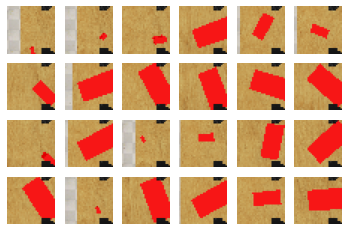

Epoch 214/500 max ; best_vloss=0.001525: 100%|██████████| 38/38 [00:00<00:00, 72.10batch/s, loss=0.000583]


Early stopping


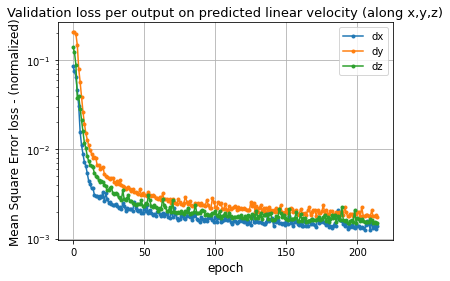

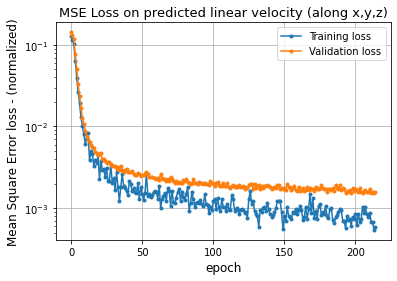

n_train=160, n_val=40
torch.Size([19851, 3, 32, 32])
torch.Size([19851, 3])
torch.Size([5215, 3, 32, 32])
torch.Size([5215, 3])
tensor(0.) tensor(0.8549)
tensor(0.0784) tensor(0.9686)
tensor(0.) tensor(0.8196)
tensor(-0.5594) tensor(0.9428)
tensor(-0.9492) tensor(0.9843)
tensor(-0.9998) tensor(0.3963)


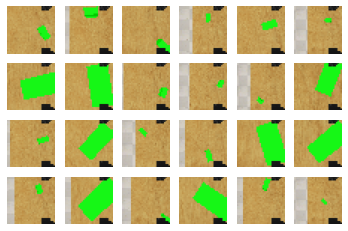

Epoch 251/500 max ; best_vloss=0.001513: 100%|██████████| 38/38 [00:00<00:00, 73.39batch/s, loss=0.000652]


Early stopping


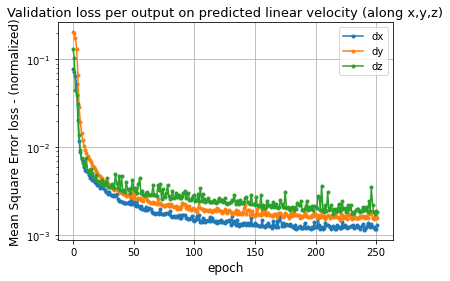

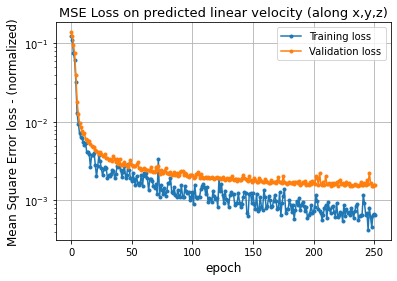

n_train=160, n_val=40
torch.Size([19851, 3, 32, 32])
torch.Size([19851, 3])
torch.Size([5215, 3, 32, 32])
torch.Size([5215, 3])
tensor(0.) tensor(0.8549)
tensor(0.) tensor(0.8353)
tensor(0.0784) tensor(0.9686)
tensor(-0.5594) tensor(0.9428)
tensor(-0.9492) tensor(0.9843)
tensor(-0.9998) tensor(0.3963)


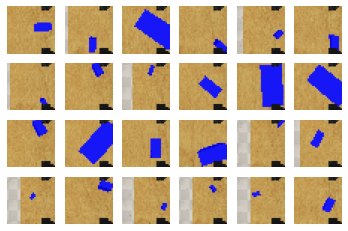

Epoch 185/500 max ; best_vloss=0.001590: 100%|██████████| 38/38 [00:00<00:00, 72.70batch/s, loss=0.000705]


Early stopping


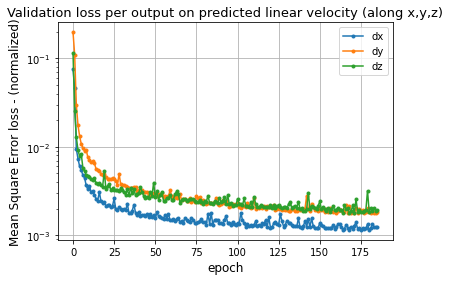

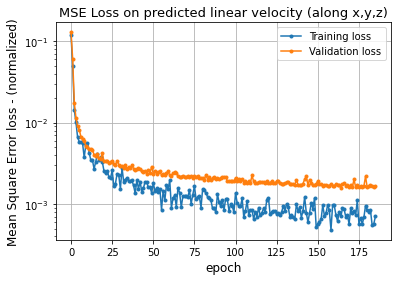

In [9]:
for col in colors:
    train_set, v_set = prepare_data(col, 200, 0.8, 0)
    check(train_set, v_set)
    model = ConvNet(n_classes=3)
    loss_log = train(model, train_set, v_set, lr=0.0005, bs=512, stop_criterion=20, max_epochs=500, model_name=f'nn32_{col}_no_aug_model')
    save_loss(loss_log, name=f'{DIR_PATH}/data/loss_nn32_{col}_no_aug_model')
    plot_loss(loss_log)

n_train=160, n_val=40
torch.Size([99255, 3, 32, 32])
torch.Size([99255, 3])
torch.Size([26075, 3, 32, 32])
torch.Size([26075, 3])
tensor(0.) tensor(1.)
tensor(0.) tensor(1.)
tensor(0.) tensor(1.)
tensor(-0.5594) tensor(0.9428)
tensor(-0.9492) tensor(0.9843)
tensor(-0.9998) tensor(0.3963)


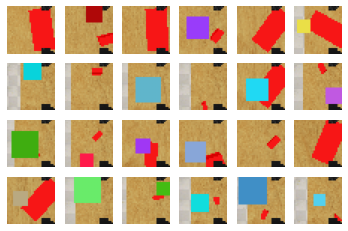

Epoch 136/500 max ; best_vloss=0.005609: 100%|██████████| 193/193 [00:05<00:00, 37.23batch/s, loss=0.003976]


Early stopping


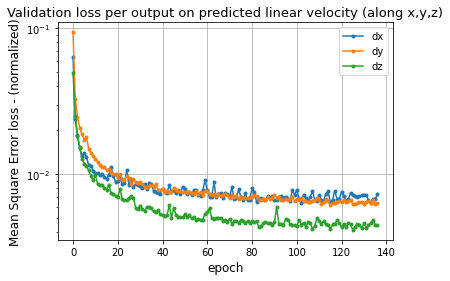

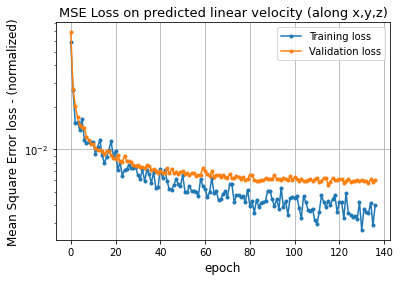

n_train=160, n_val=40
torch.Size([99255, 3, 32, 32])
torch.Size([99255, 3])
torch.Size([26075, 3, 32, 32])
torch.Size([26075, 3])
tensor(0.) tensor(1.)
tensor(0.) tensor(1.)
tensor(0.) tensor(1.)
tensor(-0.5594) tensor(0.9428)
tensor(-0.9492) tensor(0.9843)
tensor(-0.9998) tensor(0.3963)


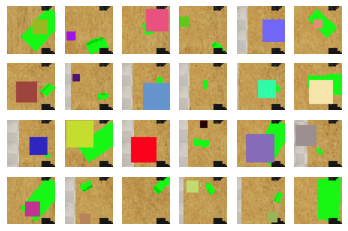

Epoch 123/500 max ; best_vloss=0.005904: 100%|██████████| 193/193 [00:05<00:00, 36.46batch/s, loss=0.003250]


Early stopping


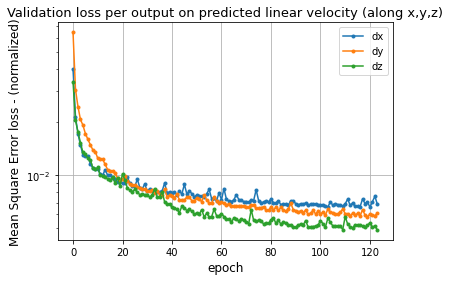

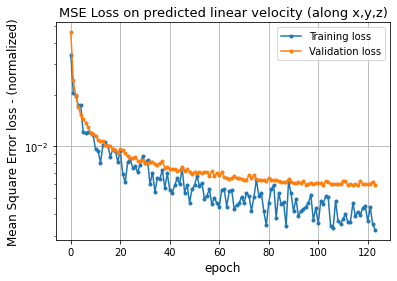

n_train=160, n_val=40
torch.Size([99255, 3, 32, 32])
torch.Size([99255, 3])
torch.Size([26075, 3, 32, 32])
torch.Size([26075, 3])
tensor(0.) tensor(1.)
tensor(0.) tensor(1.)
tensor(0.) tensor(1.)
tensor(-0.5594) tensor(0.9428)
tensor(-0.9492) tensor(0.9843)
tensor(-0.9998) tensor(0.3963)


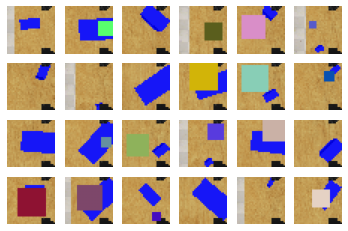

Epoch 164/500 max ; best_vloss=0.005287: 100%|██████████| 193/193 [00:05<00:00, 38.23batch/s, loss=0.002783]


Early stopping


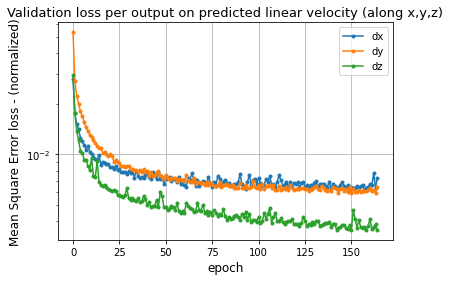

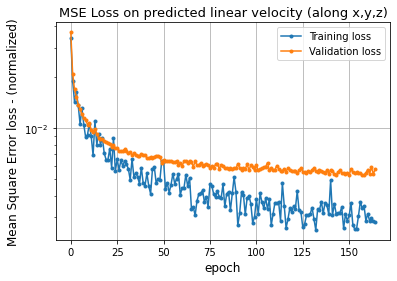

In [8]:
for col in colors:
    train_set, v_set = prepare_data(col, 200, 0.8, n_augmented=4)
    check(train_set, v_set)
    model = ConvNet(n_classes=3)
    loss_log = train(model, train_set, v_set, lr=0.0005, bs=512, stop_criterion=20, max_epochs=500, model_name=f'nn32_{col}_aug_model')
    save_loss(loss_log, name=f'{DIR_PATH}/data/loss_nn32_{col}_aug_model')
    plot_loss(loss_log)